<a href="https://colab.research.google.com/github/meriemdouider1/tp-deep-learning/blob/main/TP3_Transfer_learning_%26_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer learning & fine-tuning**

**Setup**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# **Freezing layers: understanding the trainable attribute**

**Example: the Dense layer has 2 trainable weights (kernel & bias)**

In [2]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


In [3]:
layer.weights

[<tf.Variable 'kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[-0.38771015,  0.5028647 , -0.03949308],
        [-0.13688892,  0.5011829 , -0.09314388],
        [ 0.24316669, -0.33623266,  0.73488915],
        [-0.09973121,  0.20136404, -0.07406443]], dtype=float32)>,
 <tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [4]:
layer.trainable_weights

[<tf.Variable 'kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[-0.38771015,  0.5028647 , -0.03949308],
        [-0.13688892,  0.5011829 , -0.09314388],
        [ 0.24316669, -0.33623266,  0.73488915],
        [-0.09973121,  0.20136404, -0.07406443]], dtype=float32)>,
 <tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [5]:
layer.non_trainable_weights

[]

# **Example: the BatchNormalization layer has 2 trainable weights and 2 non-trainable weights**

In [6]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


In [7]:
layer.weights

[<tf.Variable 'gamma:0' shape=(4,) dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>,
 <tf.Variable 'beta:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'moving_mean:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'moving_variance:0' shape=(4,) dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>]

In [8]:
layer.trainable_weights

[<tf.Variable 'gamma:0' shape=(4,) dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>,
 <tf.Variable 'beta:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]

Example: setting trainable to False

In [9]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


In [10]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

In [11]:
layer1.weights

[<tf.Variable 'dense_2/kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[ 0.34744167,  0.5597956 ,  0.8139596 ],
        [ 0.62888145,  0.8250325 ,  0.90051126],
        [-0.26060224,  0.58092093,  0.81355834]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [12]:
# Freeze the first layer
layer1.trainable = False

In [13]:
# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

In [14]:
initial_layer1_weights_values

[array([[ 0.34744167,  0.5597956 ,  0.8139596 ],
        [ 0.62888145,  0.8250325 ,  0.90051126],
        [-0.26060224,  0.58092093,  0.81355834]], dtype=float32),
 array([0., 0., 0.], dtype=float32)]

In [15]:
# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

1/1 [==============================] - 0s 2ms/step - loss: 0.0351


In [16]:
# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)


# **Recursive setting of the trainable attribute**


In [17]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively

# **The typical transfer-learning workflow**

In [18]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.


83689472/83683744 [==============================] - 3s 0us/step


In [19]:
base_model.trainable = False

In [20]:
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [21]:
model.layers

# **An end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset**

**Getting the data**

First, let's fetch the cats vs. dogs dataset using TFDS. 
Transfer learning is most useful when working with very small datasets. To keep our dataset small, we will use 40% of the original training data (25,000 images) for training, 10% for validation, and 10% for testing.

In [22]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete68JUU1/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


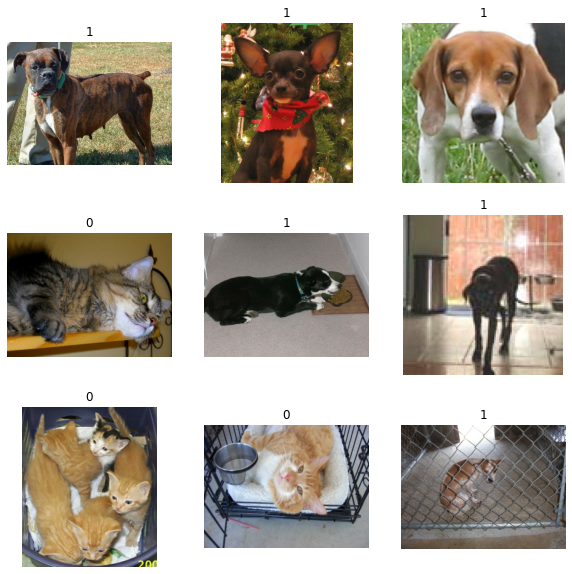

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")


 -> are the first 9 images in the training dataset -- as you can see, they're all different sizes.
 -> We can also see that label 1 is "dog" and label 0 is "cat".

 **Standardizing the data**

Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer values between 0 and 255 (RGB level values). This isn't a great fit for feeding a neural network. We need to do 2 things:
Standardize to a fixed image size. We pick 150x150.
Normalize pixel values between -1 and 1. We'll do this using a Normalization layer as part of the model itself.

In [24]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))



Besides, let's batch the data and use caching & prefetching to optimize loading speed.

In [25]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

**Using random data augmentation**

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [26]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

->Let's visualize what the first image of the first batch looks like after various random transformations:

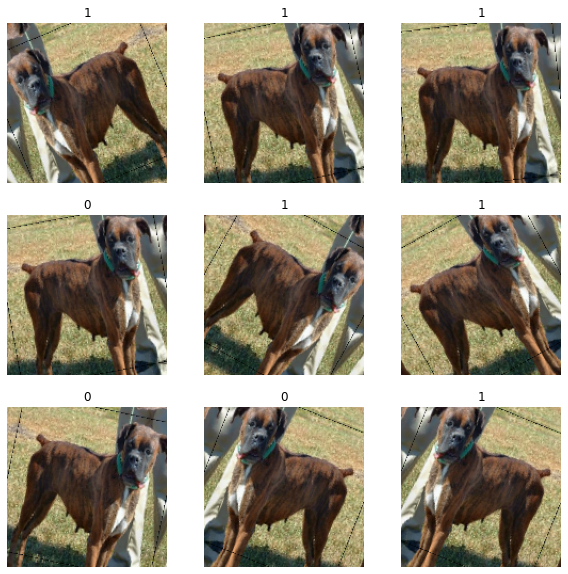

In [27]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

# **Build a model**

Now let's built a model that follows the blueprint we've explained earlier.
Note that:
We add a Normalization layer to scale input values (initially in the [0, 255] range) to the [-1, 1] range.
We add a Dropout layer before the classification layer, for regularization.
We make sure to pass training=False when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.

In [28]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False



In [29]:
# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])


In [30]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [31]:
x

<tf.Tensor 'dropout/cond/Identity:0' shape=(None, 2048) dtype=float32>

# **Train the top layer**

In [32]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 59s 203ms/step - loss: 0.1656 - binary_accuracy: 0.9264 - val_loss: 0.0923 - val_binary_accuracy: 0.9695
Epoch 2/20
291/291 [==============================] - 56s 191ms/step - loss: 0.1246 - binary_accuracy: 0.9474 - val_loss: 0.0811 - val_binary_accuracy: 0.9690
Epoch 3/20
291/291 [==============================] - 56s 191ms/step - loss: 0.1141 - binary_accuracy: 0.9490 - val_loss: 0.0766 - val_binary_accuracy: 0.9721
Epoch 4/20
291/291 [==============================] - 56s 191ms/step - loss: 0.1089 - binary_accuracy: 0.9553 - val_loss: 0.0817 - val_binary_accuracy: 0.9703
Epoch 5/20
291/291 [==============================] - 56s 191ms/step - loss: 0.1095 - binary_accuracy: 0.9550 - val_loss: 0.0739 - val_binary_accuracy: 0.9703
Epoch 6/20
291/291 [==============================] - 55s 191ms/step - loss: 0.1025 - binary_accuracy: 0.9597 - val_loss: 0.0791 - val_binary_accuracy: 0.9695
Epoch 7/20
291/291 [==========================

In [33]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

291/291 [==============================] - 188s 647ms/step - loss: 0.0803 - binary_accuracy: 0.9700 - val_loss: 0.0472 - val_binary_accuracy: 0.9781
Epoch 2/10
291/291 [==============================] - 186s 638ms/step - loss: 0.0572 - binary_accuracy: 0.9785 - val_loss: 0.0465 - val_binary_accuracy: 0.9794
Epoch 3/10
291/291 [==============================] - 186s 639ms/step - loss: 0.0420 - binary_accuracy: 0.9838 - val_loss: 0.0439 - val_binary_accuracy: 0.9832
Epoch 4/10
291/291 [==============================] - 186s 638ms/step - loss: 0.0336 - binary_accuracy: 0.9877 - val_loss: 0.0447 - val_binary_accuracy: 0.9850
Epoch 5/10
291/291 [==============================] - 185s 637ms/step - loss: 0.0331 - binary_accuracy: 0.9884 - val_loss: 0.0441 - val_binary_accuracy: 0.9850
Epoch 6/10
291/291 [==============================] - 185s 637ms/step - loss: 0.0277 - binary_accuracy: 0.9893 - val_loss: 0.0515 - val_binary_accuracy: 0.9828
Epoch 7/10
291/291 [==============================]